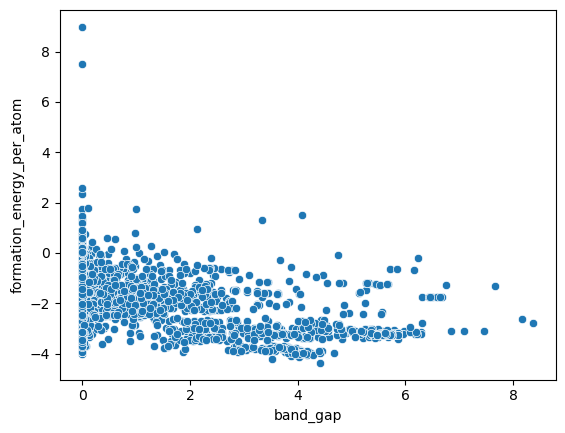

In [12]:
import seaborn as sns

%matplotlib inline

sns.scatterplot(x="band_gap", y="formation_energy_per_atom", data=valid_data);

In [13]:
# Q1

# Using pymatgen (or any alternative approach), query the Materials Project for the following properties of all ABO3 type compounds:

#     materials project identifier (material_id)
#     formula of the compound
#     number of sites in the unit cell
#     band gap
#     formation energy per atom
#     theoretical (indicates whether a material is a theoretically generated one.)
#     energy above hull

In [56]:
# Perform the query and convert the data into a Pandas DataFrame.

from mp_api.client import MPRester

import pandas as pd

with MPRester("oPsLWq6IqZdF9mRNMhRHH7M5gl622DXk") as mpr:
    data = mpr.summary.search(
        formula=["**O3"],
        fields=[
            "material_id",
            "formula_pretty",
            "nsites",
            "band_gap",
            "formation_energy_per_atom",
            "theoretical",
            "energy_above_hull"
        ]
    )
    
df = pd.DataFrame([d.dict() for d in data])
df.drop(columns=["fields_not_requested"], inplace=True)
df.dropna()
display(df)

Retrieving SummaryDoc documents:   0%|          | 0/2544 [00:00<?, ?it/s]

,nsites,formula_pretty,material_id,formation_energy_per_atom,energy_above_hull,band_gap,theoretical
0,20,NaNbO3,mp-4681,-2.833432,0.012851,2.3684,False
1,10,MnZnO3,mp-754318,-1.814413,0.005794,1.3225,True
2,20,MnAlO3,mp-1368992,-2.573144,0.161167,0.5506,True
3,5,BaBiO3,mp-545783,-2.222888,0.021211,0.0000,False
4,20,MnTlO3,mp-770870,-1.505971,0.053737,0.0000,True
...,...,...,...,...,...,...,...
2539,5,BaCdO3,mp-1183292,-1.645883,0.202881,0.0000,True
2540,10,LaMnO3,mp-1205375,-2.968812,0.161878,0.0000,False
2541,5,TlSiO3,mp-1187529,-1.862867,0.534038,0.0000,True
2542,5,GdBeO3,mp-1184468,-2.874174,0.315310,0.0000,True


In [60]:
# How many ABO3 compounds in total are there in the Materials Project?
# How many unique ABO3 formulae are there?
# What is the average number of crystals (also known as polymorphs) per ABO3 formula?

total = df.formula_pretty.count()
unique = df.formula_pretty.nunique()

print("total ABO3 count in MP:", total)
print("total unique ABO3 formulae count in MP:", unique)
print("mean number of crystals per ABO3 formula:", total / unique)

total ABO3 count in MP: 2544
total unique ABO3 formulae count in MP: 1330
mean number of crystals per ABO3 formula: 1.912781954887218


In [48]:
# What fraction of the compounds are non-theoretical?

print("fraction of compounds that are non-theoretical:", df.theoretical.value_counts()[False] / df.theoretical.count())

fraction of compounds that are non-theoretical: 0.32861635220125784


In [50]:
# The formation energies in the Materials Project are given in eV/atom.
# Create an additional column in your dataset that has the formation energies in J/mol.

df['formation_energy_per_atom_j_per_mol'] = df.formation_energy_per_atom.apply(lambda x: x * 96491.5666370759)
display(df)

,nsites,formula_pretty,material_id,formation_energy_per_atom,energy_above_hull,band_gap,theoretical,formation_energy_per_atom_j_per_mol
0,20,NaNbO3,mp-4681,-2.833432,0.012851,2.3684,False,-273402.322703
1,10,MnZnO3,mp-754318,-1.814413,0.005794,1.3225,True,-175075.572083
2,20,MnAlO3,mp-1368992,-2.573144,0.161167,0.5506,True,-248286.682894
3,5,BaBiO3,mp-545783,-2.222888,0.021211,0.0000,False,-214489.986226
4,20,MnTlO3,mp-770870,-1.505971,0.053737,0.0000,True,-145313.457438
...,...,...,...,...,...,...,...,...
2539,5,BaCdO3,mp-1183292,-1.645883,0.202881,0.0000,True,-158813.786836
2540,10,LaMnO3,mp-1205375,-2.968812,0.161878,0.0000,False,-286465.330950
2541,5,TlSiO3,mp-1187529,-1.862867,0.534038,0.0000,True,-179750.985943
2542,5,GdBeO3,mp-1184468,-2.874174,0.315310,0.0000,True,-277333.565966


In [62]:
# Let us assume that materials with energy above hull of >0.03 eV/atom are unstable and are potentially stable otherwise.
# Furthermore, band gaps (E_g) of E_g = 0, 0 < E_g ≤ 1, E_g > 1 are indicative of metallic, small band gap, large band gap for the materials.
# Create a table of the number of ABO3 crystals in each joint category, e.g., (unstable, metallic), (unstable, small band gap), etc.

df.loc[df.energy_above_hull > 0.03, 'stability'] = 'unstable'
df.loc[df.energy_above_hull <= 0.03, 'stability'] = 'potentially stable'
df.loc[df.band_gap == 0, 'band_gap_class'] = 'metallic'
df.loc[df.band_gap > 0, 'band_gap_class'] = 'small band gap'
df.loc[df.band_gap > 1, 'band_gap_class'] = 'large band gap'
df.groupby(['stability', 'band_gap_class']).size()

stability           band_gap_class
potentially stable  large band gap     525
                    metallic           197
                    small band gap     103
unstable            large band gap     465
                    metallic          1042
                    small band gap     212
dtype: int64

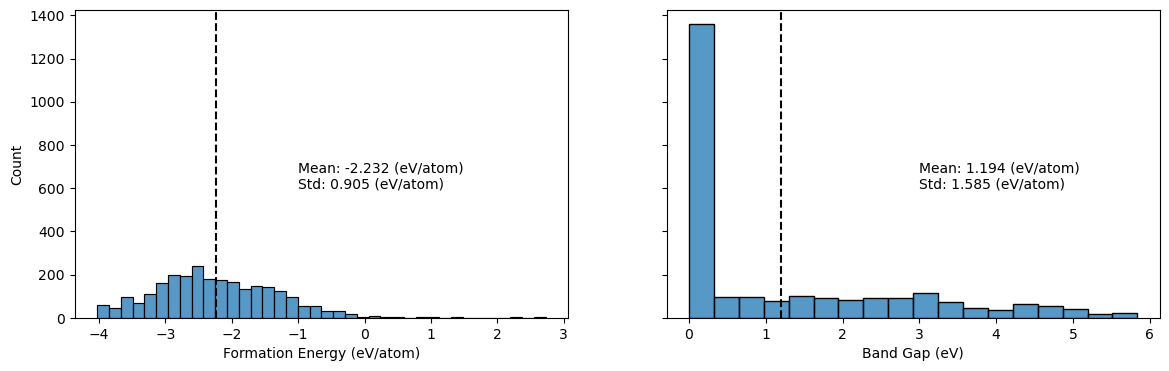

In [80]:
# Plot the distribution of (a) the formation energies per atom (in eV/atom) and 
# (b) the band gaps of all the materials.
# Annotate the plots with the average and standard deviation of each quantity.
# Ensure that all axes are labelled appropriately with units,
# i.e., something that you can potentially put in a scientific paper.

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

fe_mean = round(df.formation_energy_per_atom.mean(), 3)
fe_std = round(df.formation_energy_per_atom.std(), 3)
bg_mean = round(df.band_gap.mean(), 3)
bg_std = round(df.band_gap.std(), 3)

fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(14, 4))

fe = sns.histplot(df.formation_energy_per_atom, ax=ax1, kde=False)
fe.set(xlabel="Formation Energy (eV/atom)")
fe.text(-1, 600, ("Mean: {} (eV/atom)\nStd: {} (eV/atom)".format(fe_mean, fe_std)))
fe.axvline(fe_mean, color="black", linestyle="dashed", label="Mean")

bg = sns.histplot(df.band_gap, ax=ax2, kde=False)
bg.set(xlabel="Band Gap (eV)")
bg.text(3, 600, ("Mean: {} (eV/atom)\nStd: {} (eV/atom)".format(bg_mean, bg_std)))
bg.axvline(bg_mean, color="black", linestyle="dashed", label="Mean")

In [ ]:
# Q2

# Publicly available research data
# Researchers frequently share the datasets they have via various online platforms.
# Figshare is one such online platform. 
# We will use this example to illustrate some of the challenges in working with datasets.